# Mejorando la Visión por Computador mediante Convoluciones
Autor: [Laurence Moroney](https://www.coursera.org/instructor/lmoroney). TensorFlow in Practice (Coursera--Deep Learning.ai)

\\
Adaptado y traducido por: \\

Alejandro E. Martínez-Castro amcastro@ugr.es \\
Departamento de Mecánica de Estructuras e Ingeniería Hidráulica \\
ETS de Ingeniería de Caminos, Canales y Puertos
Universidad de Granada \\


## Introducción
En el cuaderno anterior se mostró una red neuronal profunda (Deep Neuran Network, DNN) para el problema de reconocimiento de prendas de ropa. La red contenía 3 capas: una de entrada, una oculta, y una de salida. 

Partiremos de este modelo como punto de partida. 


In [1]:
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images / 255.0
test_images=test_images / 255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.5029 - acc: 0.8232
Epoch 2/5
60000/60000 [==============================] - 3s 57us/sample - loss: 0.3774 - acc: 0.8643
Epoch 3/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3400 - acc: 0.8774
Epoch 4/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3149 - acc: 0.8851
Epoch 5/5
10000/10000 [==============================] - 0s 42us/sample - loss: 0.3566 - acc: 0.8715


La precisión del modelo será probablemente de un 89% en el conjunto de datos de entrenamiento, y un 87% en el de validación. No está mal. Pero, ¿cómo podemos hacerlo mejor?. 

Una posibilidad es utilizar **convoluciones**. Las convoluciones son filtros lineales que sirven para acentuar los rasgos, con el fin de mejorar la identificación en el entrenamiento (como se describe en https://en.wikipedia.org/wiki/Kernel_(procesamiento de imágenes))

En resumen, se toma una matriz reducida (de 3x3 o 5x5 usualmente) y se pasa por la imagen. El filtro produce una nueva imagen. Al aplicar el filtro se pierde parte de la resolución inicial: con una ventana de 3x3 sobre una imagen de 28x28, se obtiene una imagen nueva, de 26x26. 


Los filtros tienen propósito múltiple. Algunos acentúan rasgos horizontales. Otros verticales. Otros simplemente detectan bordes, etc. En en enlace anterior pueden verse varias matrices y filtros (Gaussiano, detector de bordes, etc). 

Al filtrar una imagen se obtiene una nueva imagen, que contiene los rasgos acentuados. Es más sencilla la identificación, y por tanto, es preferible entrenar sobre la imagen filtrada. 

Este es el concepto que se maneja en las Redes Neuronales Convolucionales (Convolutional Neural Networks). Se añaden algunas capas para hacer convoluciones justo antes de entrar en las capas densamente conectadas. La información que se pasa a las capas densas están mejor estructuradas, y describe mejor los rasgos. Suelen generar estructuras más precisas. 

Además de la convolución, se suele realizar otra operación de "agrupación" (Pooling). Ésta consiste en, sobre una ventana de 2x2, seleccionar el pixel con el valor más alto, y retenerlo. Tras esta operación, se reduce a la mitad el tamaño procesado. Así, desde una imagen 28x28, que tras una capa convolucional ha quedado con tamaño 26x26 con un filtro de 3x3, tras una agrupación queda en una imagen de 13x13. 

Normalmente se aplican a la vez operaciones de convolución y agrupamiento, en varias capas. Finalmente, se "aplana" la última salida para entrar en una red densa sobre la cual entrenar. 

Ejecute el bloque de código siguiente. Se trata de la misma red neuronal que se planteó para el caso de prendas de ropa, pero en este caso se añaden capas convolucionales y de agrupamiento. Esta red tardará más en entrenar, pero la precisión mejorará. 

Para que el modelo corra más rápido, es conveniente elegir un entorno de ejecución donde se emplee la GPU. 

In [2]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs=5)
test_loss = model.evaluate(test_images, test_labels)


1.15.0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_3 (Dense)              (None, 10)        

La nueva red tendrá aproximadamente un 93% en el conjunto de entrenamiento, y un 89.5% en validación. 

¡ Las convoluciones y agrupamientos han funcionado !

Ahora puede probar algo curioso. Pruebe correr el modelo de nuevo (ejecutando de nuevo todo el bloque anterior), pero para más iteraciones (epochs). Por ejemplo, 20. Explore los resultados. 

Observará que, durante el entrenamiento, la precisión va aumentando. La red detectará cada vez mejor, sobre los datos de entrenamiento, y aparentemente, introducir más iteraciones ha sido beneficioso. 

Esto no es así. Observe qué ocurre con el conjunto de datos de verificación. La precisión es del 90.89%. No ha mejorado demasiado respecto a la que había con 5 epochs. 

Lo que observamos es un fenómeno, denominado **"sobre-entrenamiento" (overfitting)**. Esto ocurre cuando la red aprende a detectar muy bien sobre los datos de entrenamiento, y en consecuencia, es menos efectiva sobre datos que la red "no ha visto" previamente. Es algo así como si toda nuestra vida hubiésemos visto zapatos rojos. Al ver por primera vez un zapato azul, podríamos pensar que no es un zapato, y nos costaría identificarlo.

Observe el código de nuevo. Veamos cómo se han construido las convoluciones. 

### Construcción del modelo: generación de datos de entrada

El paso 1 es recopilar los datos. En este caso se observa que los datos de entrada necesitan ser re-formateados. Esto es así porque la primera convolución necesita partir de un tensor que contenga todo. Por tanto, en vez de 60,000 items de 28x28x1 en una lista, es necesario partir de un tensor de 4 dimensiones, de 60,000x28x28x1. Igual ocurre con las imágenes del conjunto de datos de prueba. Si no se hace esto, se obtendrá un error en el código. 

Esta es la parte del código que realiza esta función, además de normalizar los valores a [0-1].

```
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
```



### Definición del modelo
Lo siguiente es definir el modelo. Ahora, en vez de tener la capa de entrada, con neuronas densamente conectadas, en el primer nivel, se van a añadir capas convolucionales previas. 

Los parámetros son los siguientes: 
1. El número de convoluciones que se desean generar. Podemos empezar con 64 convoluciones. Esto quiere decir que cada imagen de entrada va a generar 64 variantes. 
2. El tamaño de la rejilla de convolución: en este caso, 3x3. 
3. La función de activación a usar. En este caso usaremos `relu`, que devuelve sólo valores positivos, laminando a 0 valores iguales o menores que 0. 
4. En la primera capa, la forma del dato de entrada.

A continuación interviene una capa de tipo `MaxPooling`, que está planteada para comprimir la imagen, manteniendo los rasgos de cada convolución. Especificando (2x2) para MaxPooling, el efecto es reducir la imagen a la cuarta parte (un 25%). 

Para ver cómo va estructurándose el modelo a través de las sucesivas capas, se recurre a `model.sumary()`, que permite ver el tamaño y la forma de la red. Se observa que tras cada MaxPooling se reduce la imagen. 

Esta es la parte del código en la que se realiza una convolución y un agrupamiento (Pooling).  

```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
```



Y otra convolución...



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
```




Ahora, se "aplana" la salida. Es decir, se convierte en un vector. Tras esto, se tendrá una red neuronal del mismo tipo que la que se tenía en la entrada cuando no se usaban convoluciones. El "aplanado" se realiza con esta función: 

```
  tf.keras.layers.Flatten(),
```



A continuación se plantean 128 neuronas densamente conectadas, y 10 neuronas en la capa de salida, igual que ocurría en el caso sin usar convoluciones. Lo que se ha hecho con las convoluciones es transformar cada imagen de entrada en muchas imágenes que, cada una de ellas, acentúa un rasgo, y conduce a la misma clasificación que la imagen original. 

Es como si hubiésemos "aumentado" el conjunto de datos de entrada, modificándolo con imágenes más simples, pero mayor en número. 

Estrictamente, esto no es "aumentar" el conjunto de datos de entrada. En TensorFlow existe un procedimiento especial para aumentar ficticiamente los datos de entrada, girando las imágenes, rotándolas, o mostrándolas en espejo, para tener más datos de entrada.



```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```



A continuación se compila el modelo, se entrena, y se evalúan las funciones de pérdida y precisión del conjunto de datos de validación. 


```
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)
```




# Visualización de las Convoluciones y Poolings

A continuación visualizaremos las convoluciones gráficamente. La salida de print(test_labels[:100]) nos muestra las primeras 100 etiquetas del conjunto de datos de test. Se observa que los valores en las posiciones 0, 23 y 28 son todas iguales, (valor 9). Esto significa que son botas. 

Vamos a ver el resultado de correr las convoluciones sobre estas imágenes. Se observarán rasgos comunes. Ahora, cuando la Red Neuronal entrene, tratará de encontrar similitudes entre botas, en base a una combinación de imágenes más sencillas. 

In [3]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


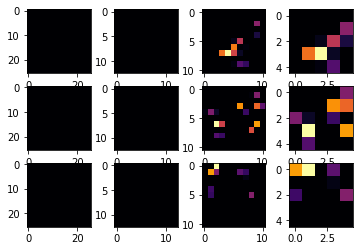

In [4]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=1
CONVOLUTION_NUMBER = 8
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

EJERCICIOS

1. Edite las capas de convoluciones. Cambie de 64, a 32 o 16. ¿Qué impacto tiene modificar el número de convoluciones en la precisión y tiempo de entrenamiento?

2. Elimine la última capa de convoluciones. ¿Qué ocurre con la precisión y tiempo de entrenamiento?

3. ¿Qué ocurre si se añaden más convoluciones?. ¿Qué impacto tiene?. Experimente. 

4. Elimine todas las convoluciones salvo la primera. ¿Qué sucede?. 

5. En el cuaderno anterior se implementó una función-objeto callback, para chequear la precisión y parar el entrenamiento cuando se alcance. Pruebe si se puede implementar aquí también.

In [5]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

1.15.0
11493376/11490434 [==============================] - 0s 0us/step
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1509 - acc: 0.9551
Epoch 2/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0528 - acc: 0.9840
Epoch 3/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0329 - acc: 0.9898
Epoch 4/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0216 - acc: 0.9933
Epoch 5/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0154 - acc: 0.9948
Epoch 6/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0110 - acc: 0.9967
Epoch 7/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0085 - acc: 0.9974
Epoch 8/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0068 - acc: 0.9977
Epoch 9/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0057 -